In [1]:
import os
import sys
import shutil
import warnings
import numpy as np
import time
from tqdm import tqdm_notebook
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append('..')
warnings.simplefilter('ignore')

from keras.models import load_model
import keras.backend as K
import tensorflow as tf

from segmentation_models.metrics import iou_score

from albumentations import Normalize, Compose

from pascal_voc_data import PascalVocGenerator
from utils import get_iou, load_graph

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
height = 513
width = 513
num_classes = len(PascalVocGenerator.classes)
batch_size = 1

In [11]:
data_gen = PascalVocGenerator(
    '/data/VOC2012/ImageSets/Segmentation/trainval.txt',
    '/data/VOC2012/JPEGImages/',
    '/data/VOC2012/SegmentationClass/',
    batch_size, (height, width), False, None, 1
)

In [3]:
graph = load_graph('DeepLab_V3_513_CPU.pb')

In [4]:
def expand_prediction(pred, height, width, num_classes):
    exp_pred = np.zeros((height, width, num_classes), np.float)
    for _h in range(height):
        for _w in range(width):
            exp_pred[_h, _w, pred[_h, _w]] = 1.
    return exp_pred

In [17]:
x = graph.get_tensor_by_name('import/ImageTensor:0')
y = graph.get_tensor_by_name('import/SemanticPredictions:0')
results = []
# warm CPU or GPU
data_gen.images = np.append(data_gen.images[:1], data_gen.images)
with tf.Session(graph=graph) as sess:
    for _i, (image, true_mask) in tqdm_notebook(enumerate(data_gen), total=len(data_gen)):
        start = time.time()
        pred = sess.run(y, feed_dict={
            x: image
        })
        end = time.time()
        for _j in range(batch_size):
            pred_mask = expand_prediction(pred[_j], height=height, width=width, num_classes=num_classes)
            iou = get_iou(true_mask[_j], pred_mask)[0]
            results.append([iou, end - start])
#         break
results = results[1:]
data_gen.images = data_gen.images[1:]

In [18]:
pred_mask_cl = data_gen.categorical_to_mask(pred_mask)
true_mask_cl = data_gen.categorical_to_mask(true_mask[0])

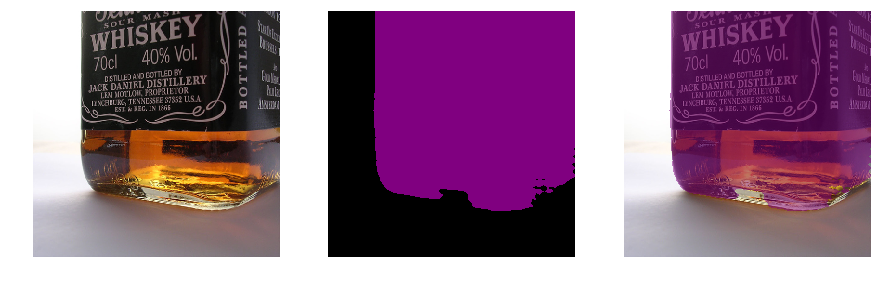

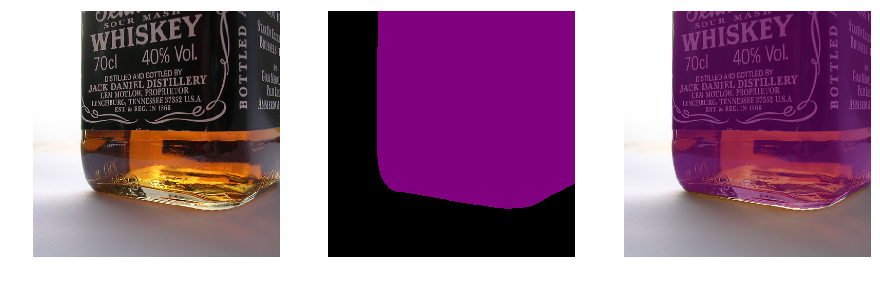

In [19]:
PascalVocGenerator.segmentation_plot(image[0], pred_mask_cl).show()
PascalVocGenerator.segmentation_plot(image[0], true_mask_cl).show()

In [20]:
results = np.array(results)
results[:, 0].mean(), results[:, 1].mean()

(0.5869456429285007, 0.02236366239234094)